In [7]:

import sys, os
sys.path.append('./pyFM/')  # My code builds on the pyFM.mesh.TriMesh class
sys.path.append('./VisualizationTools/') # This is just for visualization purposes


In [8]:
import large_mesh as lmu
import VisualizationTools as plu

from pyFM.mesh import TriMesh

# 1 - Computing the approximate spectrum for a dense mesh

In [4]:
# Load mesh, normalize and center for simplicity
mesh1 = TriMesh("./data/40.off",area_normalize=True, center=True).process(k=0, intrinsic=True)
mesh1.n_vertices

95642

In [5]:
# Define parameters for the process
process_params = {
    'dist_ratio': 3, # rho = dist_ratio * average_radius
    'self_limit': .25,  # Minimum value for self weight
    'correct_dist': False,
    'interpolation': 'poly',
    'return_dist': True,
    'adapt_radius': True,
    'n_jobs':10,
    'n_clusters': 100,
    'verbose': True
}

n_samples = 2000

# Check the docstring for the meaning of each parameter
print(lmu.process_mesh.__doc__)


    Build matrices U, A_bar; W_bar and distance matrix

    Parameters:
    ----------------------
    mesh1         : pyFM.TriMesh object with n vertices
    n_samples     : number of samples
    dist_ratio    : rho = dist_ratio * average_radius
    update_sample : whether to add unseen vertices to the sample
    interpolation : 'poly', 'linear', 'exp' - type of local function
    correct_dist  : If True, Replace dijkstra dist with euclidean after dijkstra
    return_dist   : If True, return the sparse distance matrix
    adapt_radius  : Whether to use the adaptive radius sttrategy
    self_limit    : Minimum value for self weight
    batch_size    : Size of batches to use
    n_clusters    : Number of cluster to use to first divide the shape (memory issues)
    n_jobs        : number of parallel workers to use

    Output
    ----------------------
    U : (n,p) sparse local functions at each columns
    A_bar : U^T A U
    W_bar : U^T W U
    subsample : indices of sampled points
 

In [6]:
# Computes the approximate spectrum, Wb is used for \overline{W} and Ab for \overline{A}
# Evects1 are values at samples of sub1, distmat1 is the distance matrix
# Dense N1 x K eigenvector matrix can be obtained with U1 @ evects1
U1, Ab1, Wb1, sub1, distmat1 = lmu.process_mesh(mesh1, n_samples, **process_params)
evals1, evects1 = lmu.get_approx_spectrum(Wb1, Ab1, verbose=True)

Sampling 2000 vertices out of 95642...
	2912 samples extracted in 0.79s
Computing First Dijkstra run...


  0%|          | 0/100 [00:00<?, ?it/s]

	Done in 3.79s

Update sampled points
0 vertices have been added to the sample

Update radius :
Iteration 1 : Modifying 6 sampled points
	Recomputing 1136 values

Iteration 2 : Modifying 2 sampled points
	Recomputing 372 values

Removed 1250 values
Nonzero elements :
	Mean : 7.57 +- 1.20
	Min : 1	Max: 12
Computing 150 eigenvectors
	Done in 17.93 s


In [9]:
# Visualize the spectrum as values at the samples of sub1
plu.plot(mesh1, points=sub1, cmap_p=evects1[:,1], colormap="coolwarm")

AttributeError: module 'VisualizationTools' has no attribute 'plot'

In [ ]:
# You can also check the "dense" eigenvector
plu.plot(mesh1, cmap=U1 @ evects1[:,1], colormap="coolwarm")

# 2 - Shape Matching using approximate spectrum

In [11]:
# Let's first load the meshes

mesh1 = TriMesh("./data/13.off",area_normalize=True, center=True).process(k=0, intrinsic=True)
mesh2 = TriMesh("./data/42.off",area_normalize=True, center=True).process(k=0, intrinsic=True)

#plu.double_plot(mesh1, mesh2)

In [12]:
# Define parameters for the process
process_params = {
    'dist_ratio': 3, # rho = dist_ratio * average_radius
    'self_limit': .25,  # Minimum value for self weight
    'correct_dist': False,
    'interpolation': 'poly',
    'return_dist': True,
    'adapt_radius': True,
    'n_jobs':10,
    'n_clusters': 100,
    'verbose': False
}

n_samples = 2000

In [13]:
U1, Ab1, Wb1, sub1, distmat1 = lmu.process_mesh(mesh1, n_samples, **process_params)
evals1, evects1 = lmu.get_approx_spectrum(Wb1, Ab1, verbose=True)

U2, Ab2, Wb2, sub2, distmat2 = lmu.process_mesh(mesh2, n_samples, **process_params)
evals2, evects2 = lmu.get_approx_spectrum(Wb2, Ab2, verbose=True)

Computing 150 eigenvectors
	Done in 14.80 s
Computing 150 eigenvectors
	Done in 18.48 s


In [14]:
import pyFM.spectral as spectral
from pyFM.spectral.nn_utils import knn_query
from pyFM.refine.zoomout import zoomout_refine

import matplotlib.pyplot as plt

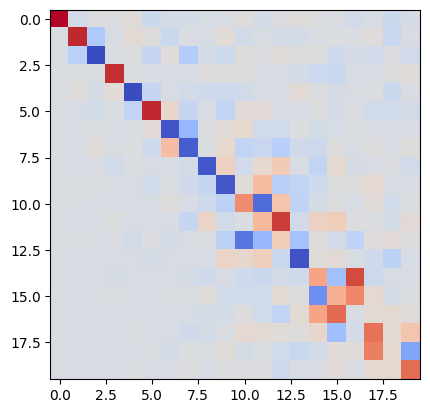

In [15]:
# Compute an initial approximate functional map
p2p_21_sub_init = knn_query(mesh1.vertices[sub1], mesh2.vertices[sub2], k=1, n_jobs=10)
# We compute the initial functional map using the approximate spectrum here (same method that will be used inside ZoomOut)
FM_12_init = spectral.p2p_to_FM(p2p_21_sub_init, evects1[:,:20], evects2[:,:20], A2=Ab2)

plt.imshow(FM_12_init, cmap='coolwarm')

In [16]:
# You can perform ZoomOut like if you had resampled the whole mesh. This gives you a funcitonal map and a point-to-point map between the two samples (not the whole meshes)
FM_12_zo, p2p_21_sub_zo = zoomout_refine(FM_12_init, evects1, evects2, nit=16, step=5, A2=Ab2, return_p2p=True, n_jobs=10, verbose=True)

  0%|          | 0/16 [00:00<?, ?it/s]

In [17]:
# If you need a dense point-to-point map, you can use FM_12_zo as the functional map between the dense shapes. If needed, an accelerated version of this is described in the paper, but I found that its implementation is very machine-dependant.
p2p_21_zo = spectral.FM_to_p2p(FM_12_zo, U1@evects1, U2@evects2, n_jobs=10)

In [ ]:
plu.plot_p2p(mesh1, mesh2, p2p_21_zo, pretty=True)